In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from regions import Regions
import numpy as np
from astropy import units as u
from astropy.nddata import Cutout2D
import pandas as pd
import cv2
import os
import shutil
from scipy import ndimage
from skimage.io import imread,imshow
import PIL
from PIL import Image
import shortuuid
from tqdm import tqdm
import random

# Loading the fits file

In [7]:
hdul = fits.open('../../data files/ngc0628_miri_f770w_anchored.fits')
regions = Regions.read('../../data files/jwst-bubbles-v0p1.reg',format='ds9')
hdul.info()

Filename: ../../data files/ngc0628_miri_f770w_anchored.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (2968, 2938)   float64   


## Splitting the original image, bubble image and the masked image.

# Creating training images from cutouts

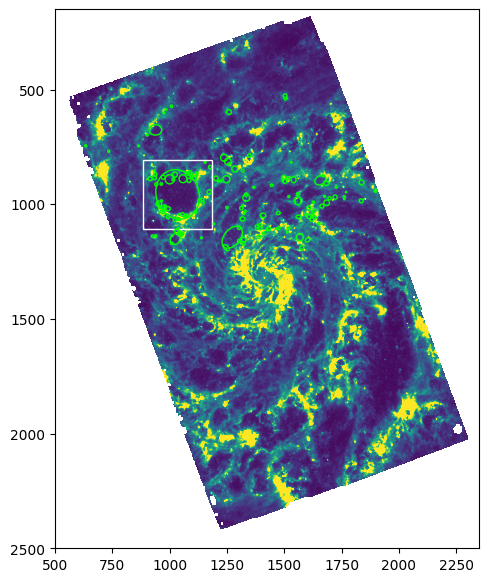

In [8]:
data = hdul[0].data
header = hdul[0].header

#Perform coordinate transforamtion:
wcs = WCS(header)

fig, ax = plt.subplots(figsize=(7,7))
#Show map in World Coordinate System transform from axes
#plt.subplot(projection=wcs)


plt.ylim(2500,150)
plt.xlim(500,2350)
ax.imshow(data, vmin=0, vmax=7)

for i,region in enumerate(regions[100:250]):
    pixel_region = region.to_pixel(wcs)
    if region == regions[132]:
        position = (pixel_region.center.x,pixel_region.center.y)
        size = u.Quantity((300,300), u.pixel)
        cutout = Cutout2D(data,position,size)
        cutout.plot_on_original(color='white')
    pixel_region.plot(ax=ax)

# Multiple masks in a single input image when matrix elements go from 0 to 1

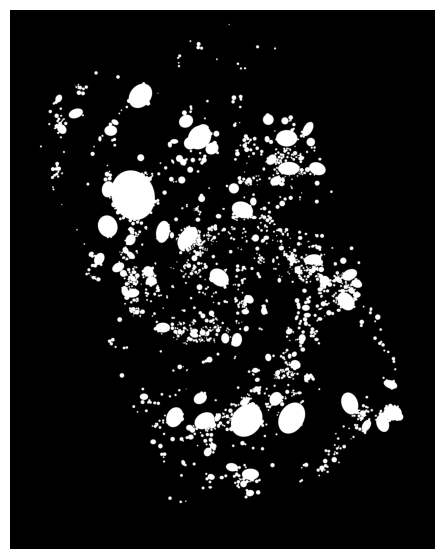

In [9]:
fig, ax = plt.subplots(figsize=(7,7))
shape = data.shape

final_matrix = np.zeros((shape))

for i,region in enumerate(regions):
    pixel_region = region.to_pixel(wcs)
    mask = pixel_region.to_mask(mode='exact')
    mask_matrix = mask.to_image(shape)
    final_matrix += mask_matrix
    
final_matrix[final_matrix > 1] = 1
#final_matrix[final_matrix == 0] = np.nan
plt.ylim(2500,150)
plt.xlim(500,2350)
plt.imshow(final_matrix,cmap='gray')
plt.gca().set_axis_off() # responsible for removing axes.
#plt.savefig('masked.png',bbox_inches='tight',pad_inches = 0)
#plt.colorbar()

# Rotation of original cutout

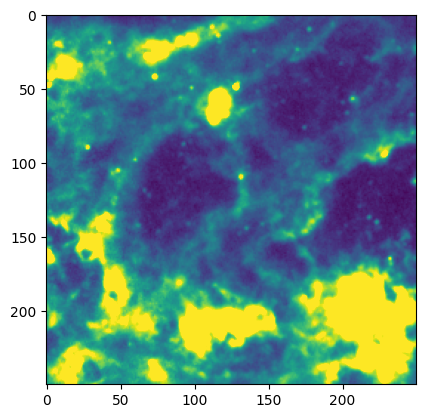

In [29]:
region = regions[0].to_pixel(wcs)
position = (pixel_region.center.x,pixel_region.center.y)
size = u.Quantity((250,250), u.pixel)

cutout_original = Cutout2D(data,position,size)
plt.imshow(cutout_original.data,vmin=0,vmax=7)

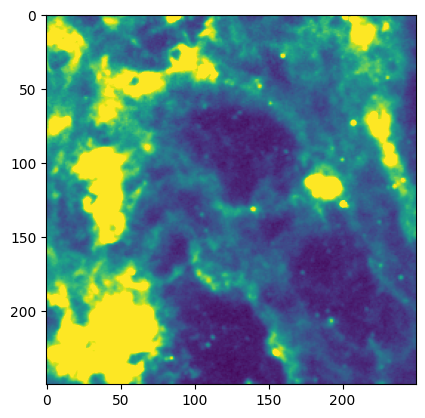

In [37]:
img = cutout_original.data

rot_image = ndimage.rotate(img, 270, reshape=True,order=1)
plt.imshow(rot_image,vmax=7,vmin=0)


# mask cutout

<Axes: >

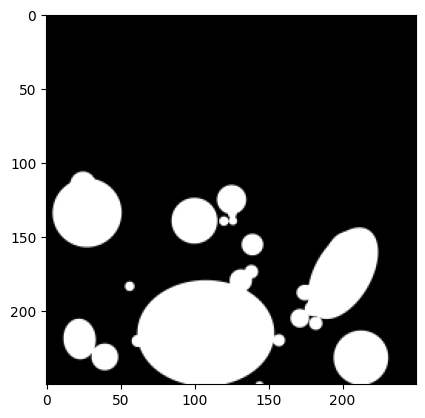

In [10]:
region = regions[0].to_pixel(wcs)
position = (region.center.x,region.center.y)
size = u.Quantity((250,250), u.pixel)

cutout = Cutout2D(final_matrix,position,size)

plt.imshow(cutout.data,cmap='gray')
cutout.plot_on_original(color='white')

# Rotation

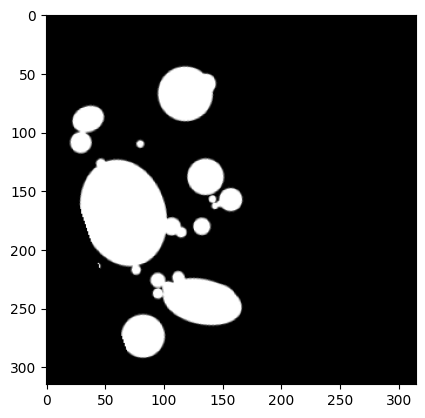

In [11]:
rot_angles = np.array([72,144,216,288])
img = cutout.data
for i in (rot_angles):
    rot_image = ndimage.rotate(img, i, reshape=True,order=1)
    plt.imshow(rot_image,cmap='gray')
    #plt.savefig(f'rot_{i}.png')

# Flip(Horizontally)

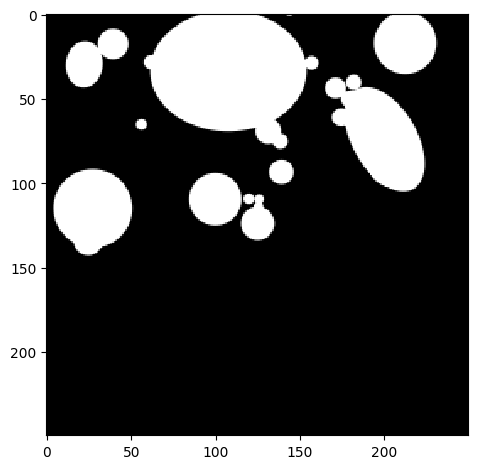

In [16]:
image = cutout.data

image = np.array(list(reversed(image)))
imshow(image)

# Flip(Vertical axis)

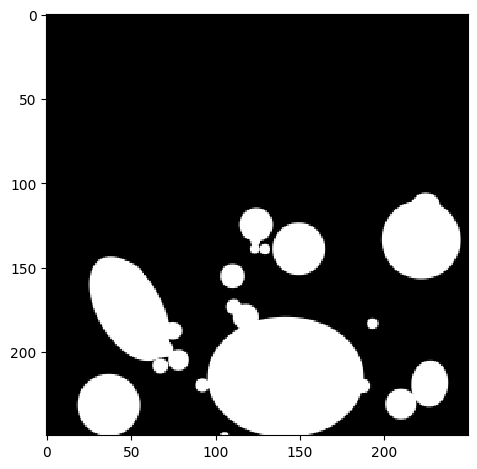

In [18]:
image = cutout.data

image = np.array([list(reversed(row)) for row in image])
imshow(image)

# Creating dataset

In [46]:
parent_folder = '../../../../../../Applications/PHYS499/dataset10k/'

shutil.rmtree(f'{parent_folder}')
os.makedirs(parent_folder)
original_folder = f'{parent_folder}/original/'
os.mkdir(original_folder)
masked_folder = f'{parent_folder}/masked/'
os.mkdir(masked_folder)

rot_angles = np.array([90,180,270])

for i,region in tqdm(enumerate(regions),total=len(regions)):
    id_og = shortuuid.uuid()
    pixel_region = region.to_pixel(wcs)
    position = (pixel_region.center.x,pixel_region.center.y)
    size = u.Quantity((300,300), u.pixel)
    
    cutout_original = Cutout2D(data,position,size)
    cutout_mask = Cutout2D(final_matrix,position,size)
    
    #original cutout
    plt.imshow(cutout_original.data,vmin=0,vmax=7)
    plt.gca().set_axis_off() # responsible for removing axes.
    plt.savefig(f'{original_folder}/original_{id_og}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()
    
    #masked cutout
    plt.imshow(cutout_mask.data,cmap='gray')
    plt.gca().set_axis_off() # responsible for removing axes.
    plt.savefig(f'{masked_folder}/masked_{id_og}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()
    
    #rotations for original as well masks
    for i in (rot_angles):
        id_rot = shortuuid.uuid()
        
        rot_image = ndimage.rotate(cutout_original.data,i,reshape=True,order=1)
        plt.imshow(rot_image,vmax=7,vmin=0)
        plt.gca().set_axis_off()
        plt.savefig(f'{original_folder}/original_{id_rot}.png',bbox_inches='tight',pad_inches = 0)
        plt.clf()
        
        rot_mask = ndimage.rotate(cutout_mask.data, i, reshape=True,order=1)
        plt.imshow(rot_mask,cmap='gray')
        plt.gca().set_axis_off()
        plt.savefig(f'{masked_folder}/masked_{id_rot}.png',bbox_inches='tight',pad_inches = 0)
        plt.clf()
        
    #horinzontal flip
    id_hor = shortuuid.uuid()
    
    hor_image = np.array(list(reversed(cutout_original.data)))
    plt.imshow(hor_image,vmin=0,vmax=7)
    plt.gca().set_axis_off()
    plt.savefig(f'{original_folder}/original_{id_hor}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()
    
    hor_mask = np.array(list(reversed(cutout_mask.data)))
    plt.imshow(hor_mask,cmap='gray')
    plt.gca().set_axis_off()
    plt.savefig(f'{masked_folder}/masked_{id_hor}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()
    
    #vertical flip
    id_ver = shortuuid.uuid()
    
    ver_image = np.array([list(reversed(row)) for row in cutout_original.data])
    plt.imshow(ver_image,vmin=0,vmax=7)
    plt.gca().set_axis_off()
    plt.savefig(f'{original_folder}/original_{id_ver}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()
    
    ver_mask = np.array([list(reversed(row)) for row in cutout_mask.data])
    plt.imshow(ver_mask,cmap='gray')
    plt.gca().set_axis_off()
    plt.savefig(f'{masked_folder}/masked_{id_ver}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()

 17%|██████                              | 1695/10170 [24:27<2:02:19,  1.15it/s]


<Figure size 640x480 with 0 Axes>

## Splitting the data into training data sets

In [53]:
num_of_originals = len([name for name in os.listdir(original_folder)])
num_of_masks = len([name for name in os.listdir(masked_folder)])


In [54]:
training_idx = next(os.walk(original_folder))[2] #all the ids
print(training_idx[0])
print(training_idx[0][9:-4])

original_iemAwpb8zaFLg7BbZh2jB3.png
iemAwpb8zaFLg7BbZh2jB3


In [59]:
os.mkdir(f'{parent_folder}/stage2_train')

num_of_training_images = int(num_of_originals)

training_idx = next(os.walk(original_folder))[2] #all the ids
random.shuffle(training_idx) #random sampling of all the images ids

train_folder = f'{parent_folder}/stage2_train/'
for iterations in range(num_of_training_images):

    i = training_idx[iterations][9:-4]
    original_filename = f"original_{i}.png"
    dst_original_folder = f"{train_folder}/{original_filename}"
    os.mkdir(dst_original_folder)
    
    if (os.path.exists(dst_original_folder)):
        dst_image_folder = f"{dst_original_folder}/image"
        os.mkdir(dst_image_folder)

        dst_masked_folder = f"{dst_original_folder}/mask"
        os.mkdir(dst_masked_folder)

        
    masked_filename = f"masked_{i}.png"
    
    src_path_original = os.path.join(original_folder,original_filename)
    src_path_masked = os.path.join(masked_folder,masked_filename)
    
    dst_path_original = os.path.join(dst_image_folder,original_filename)
    dst_path_masked = os.path.join(dst_masked_folder,original_filename)
    
    shutil.copy(src_path_original,dst_path_original)
    shutil.copy(src_path_masked,dst_path_masked)
    
# shutil.rmtree(f'{parent_folder}/original/')
# shutil.rmtree(f'{parent_folder}/masked/')